In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Garbage/dataset.zip' -d '/content/'

In [ ]:
import numpy as np
import pandas as pd
import os


In [ ]:
import sys

from typing import Dict, Optional, Tuple
from pathlib import Path

import math

import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from tensorflow.keras import backend #Keras version 2.1.6
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate, LeakyReLU, Input, Conv2D, MaxPooling2D

from tensorflow.keras import layers

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
#from PIL import Image

from sklearn.metrics import r2_score
from sklearn.utils import shuffle

%matplotlib inline

In [ ]:
df = pd.read_csv('/content/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/IND_and_Nep_AQI_Dataset.csv')
df.head()

,Location,Filename,Year,Month,Day,Hour,AQI,PM2.5,PM10,O3,CO,SO2,NO2,AQI_Class
0,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-9.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
1,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-8.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
2,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-7.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
3,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-6.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
4,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-5.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy


In [ ]:
df = shuffle(df)

df.sample(frac=1).reset_index(drop=True)

number_of_rows = 3000
sub_dfs = [df[i:i + number_of_rows] for i in range(0, df.shape[0], number_of_rows)]
for idx, sub_df in enumerate(sub_dfs):
    sub_df.to_csv(f'frag3000_{idx}.csv', index=False)

In [ ]:
df = pd.read_csv('/content/frag3000_1.csv')
df.head(15)

In [ ]:
def build_x(path):
    train_img = []
    for i in range(df.shape[0]):
        img = image.load_img(path + df['Filename'][i])
        img = image.img_to_array(img)
        img = tf.keras.applications.vgg16.preprocess_input(img)
        #img = img / 255        # with respect to imagenet, no scaling be used
        train_img.append(img)

    x = np.array(train_img)
    return x

In [ ]:
x_origin = build_x('/content/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/All_img/')

In [ ]:
x_origin.shape

(3000, 224, 224, 3)

In [ ]:
pm10 =pd.DataFrame(df['PM10'])
pm10

,PM10
0,132.00
1,272.00
2,199.00
3,64.00
4,48.66
...,...
2995,90.00
2996,83.00
2997,194.00
2998,272.00


In [ ]:
x_origin_train, x_origin_temp, y_train, y_temp = train_test_split(x_origin, pm10, train_size=0.8, shuffle=True)

In [ ]:
x_origin_valid, x_origin_test, y_valid, y_test = train_test_split(x_origin_temp, y_temp, test_size=0.5, shuffle=True)

In [ ]:
x_origin_train.shape

(2400, 224, 224, 3)

In [ ]:
y_train.shape

(2400, 1)

In [ ]:
x_origin = []
x_origin_temp = []
y_temp = []
y = []

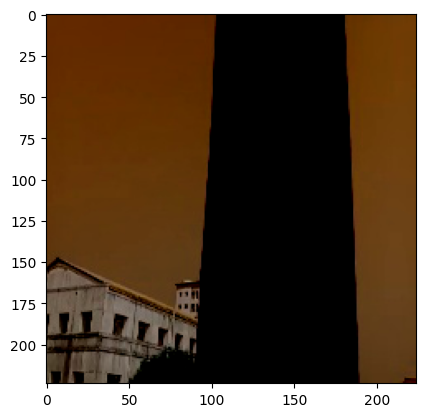

In [ ]:
plt.imshow(x_origin_test[10]/255)

In [ ]:
y_test = y_test.reset_index(drop=True)
y_test

,PM10
0,299.0
1,139.0
2,90.8
3,40.0
4,21.0
...,...
295,168.0
296,53.0
297,358.0
298,169.0


In [ ]:
y_test.head(15)

,PM10
0,299.00
1,139.00
2,90.80
3,40.00
4,21.00
5,345.00
6,48.66
7,36.00
8,188.00
9,177.00


In [ ]:
pre_trained_model  = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
for layer in pre_trained_model.layers:
    layer.trainable = False
    print(layer.name)


58889256/58889256 [==============================] - 0s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [ ]:
x1 = Flatten()(pre_trained_model.output)
fc1 = Dense(512, activation = 'relu')(x1)
fc2 = Dense(512, activation = 'relu')(fc1)
x = Dense(1, activation='linear')(fc2)
model = Model(pre_trained_model.input, x)

opt = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='mse', optimizer=opt)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
weight_path="{}_aqi.best.hdf5".format('vgg16')

In [ ]:
callback = [
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto'),
    ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                    save_best_only=True, mode='min', save_weights_only = True)]
history = model.fit(x=x_origin_train, y=y_train, validation_data=(x_origin_valid, y_valid), batch_size=16, epochs=150, callbacks=callback)

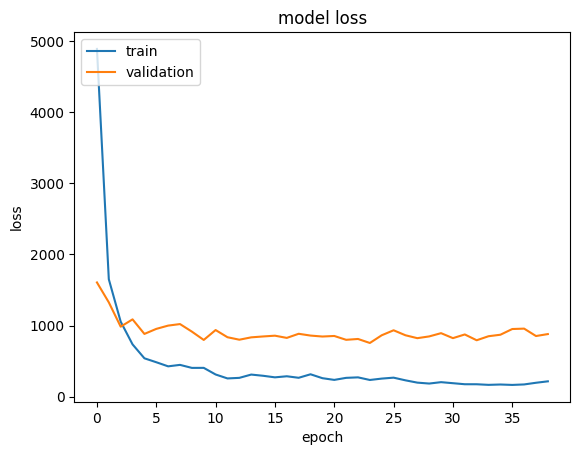

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.load_weights(weight_path)

In [ ]:
loss = model.evaluate(x=x_origin_test, y=y_test, batch_size=16)
print('RMSE is :', loss ** 0.5)

19/19 [==============================] - 1s 64ms/step - loss: 1103.2196
RMSE is : 33.214749803245354


In [ ]:
x_origin_test

In [ ]:
y_predict = model.predict(x_origin_test)

10/10 [==============================] - 6s 100ms/step


In [ ]:
from sklearn.metrics import r2_score

r2_score(y_test, y_predict)

0.8955210336306098

In [ ]:
y_predict_pm10 = np.zeros(len(y_predict))

for i in range(len(y_predict)):
    if y_predict[i] <= 54:
        y_predict_pm10[i] = 0
    elif y_predict[i] >= 55 and y_predict[i] <= 154:
        y_predict_pm10[i] = 1
    elif y_predict[i] >= 155 and y_predict[i] <= 254:
        y_predict_pm10[i] = 2
    elif y_predict[i] >= 255 and y_predict[i] <= 354:
        y_predict_pm10[i] = 3
    elif y_predict[i] >= 355 and y_predict[i] <= 424:
        y_predict_pm10[i] = 4
    elif y_predict[i] > 424:
        y_predict_pm10[i] = 5
    else:
        print('Exception Occured!')

y_predict_pm10 = y_predict_pm10.astype(int)


y_predict_pm10

Exception Occured!
Exception Occured!
Exception Occured!


array([3, 1, 1, 1, 0, 3, 0, 0, 2, 2, 1, 1, 2, 1, 2, 2, 4, 0, 2, 1, 0, 1,
       0, 1, 2, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 0, 2, 1, 1, 1, 2, 0, 2, 0,
       1, 3, 2, 1, 2, 0, 3, 1, 1, 1, 2, 2, 1, 1, 0, 3, 1, 3, 1, 2, 1, 3,
       1, 1, 0, 3, 2, 2, 2, 1, 4, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 3, 2,
       1, 2, 1, 1, 2, 1, 1, 0, 2, 2, 2, 1, 0, 2, 2, 0, 3, 0, 0, 2, 0, 1,
       1, 4, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 4, 2, 1, 1, 3, 0, 1, 0,
       1, 1, 1, 3, 1, 1, 2, 0, 2, 1, 0, 2, 1, 1, 1, 0, 2, 4, 1, 1, 1, 4,
       2, 1, 2, 0, 1, 1, 3, 0, 1, 0, 1, 2, 2, 0, 4, 1, 1, 2, 1, 1, 1, 1,
       4, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 3, 5, 2, 0, 3, 1, 1, 0, 1, 1,
       1, 3, 0, 3, 1, 1, 1, 2, 2, 1, 0, 1, 1, 1, 0, 2, 2, 2, 1, 1, 0, 1,
       1, 2, 1, 1, 2, 1, 0, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 0, 3, 3,
       1, 1, 2, 2, 1, 1, 4, 1, 2, 1, 3, 2, 1, 0, 0, 5, 1, 1, 2, 1, 0, 2,
       2, 1, 1, 1, 1, 0, 1, 2, 1, 1, 4, 3, 1, 1, 0, 2, 2, 2, 1, 0, 2, 1,
       4, 1, 1, 1, 0, 2, 1, 0, 1, 2, 1, 2, 2, 0])

In [ ]:
y_test = y_test.to_numpy().tolist()
y_test

In [ ]:
y_test[1][0]

139.0

In [ ]:
#Classify the Ground Truth PM10 concentration to the air quality levels

y_test_pm10 = np.zeros(len(y_test))

for i in range(len(y_test)):
    if int(y_test[i][0])  <= 54:
        y_test_pm10[i] = 0
    elif int(y_test[i][0]) >= 55 and int(y_test[i][0]) <= 154:
        y_test_pm10[i] = 1
    elif int(y_test[i][0]) >= 155 and int(y_test[i][0]) <= 254:
        y_test_pm10[i] = 2
    elif int(y_test[i][0]) >= 255 and int(y_test[i][0]) <= 354:
        y_test_pm10[i] = 3
    elif int(y_test[i][0]) >= 355 and int(y_test[i][0]) <= 424:
        y_test_pm10[i] = 4
    elif int(y_test[i][0]) > 424:
        y_test_pm10[i] = 5
    else:
        print('Exception Occured!')

y_test_pm10 = y_test_pm10.astype(int)


y_test_pm10

In [ ]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test_pm10, y_predict_pm10)

0.6049974398361495

In [ ]:
#---Classification Accuracy for PM2.5---------

t = 0
n = 0

for i in range(len(y_predict_pm10)):
    if y_predict_pm10[i] == y_test_pm10[i]:
        t = t + 1
    else:
        n = n + 1

acc = t / len(y_predict_pm10)

print('Acc: ', acc, ' True: ', t, ' False: ', n)

Acc:  0.7633333333333333  True:  229  False:  71


In [ ]:
from sklearn.metrics import f1_score

f1_score(y_test_pm10, y_predict_pm10, average='macro')

0.6267671234166918

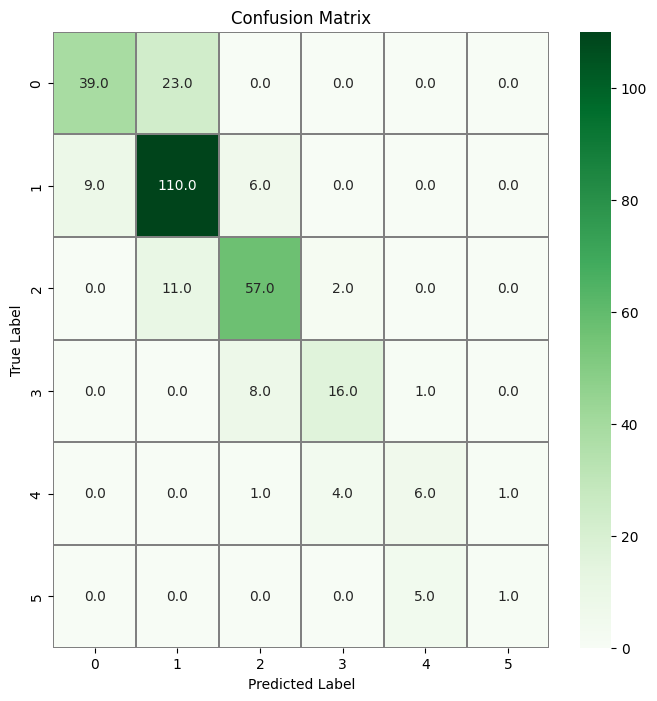

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
Y_pred_classes = y_predict_pm10
Y_true = y_test_pm10
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

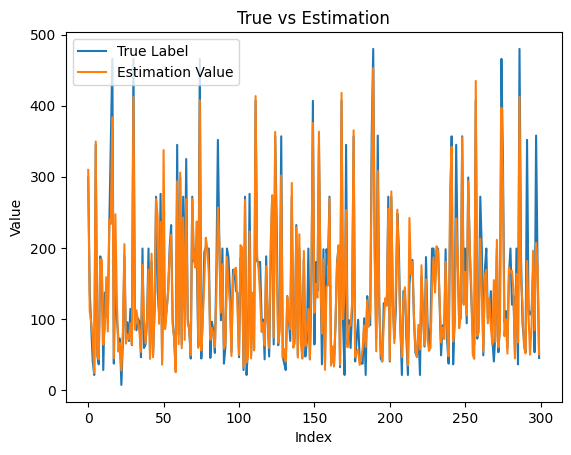

In [ ]:
plt.plot(y_test, label='True Label')
plt.plot(y_predict, label='Estimation Value')

# set the x-axis label
plt.xlabel('Index')

# set the y-axis label
plt.ylabel('Value')

# set the plot title
plt.title('True vs Estimation')

# Adding a legend
plt.legend()

# display the plot
plt.show()

In [ ]:
custom_model  = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
for layer in custom_model.layers:
    layer.trainable = False

In [ ]:
x1 = Flatten()(custom_model.output)
fc1 = Dense(512, activation = 'relu')(x1)
fc2 = Dense(512, activation = 'relu')(fc1)
x = Dense(1, activation='linear')(fc2)
custom_model = Model(custom_model.input, x)

opt = tf.keras.optimizers.Adam(lr=0.0001)
custom_model.compile(loss='mse', optimizer=opt)
custom_model.summary()

In [ ]:
custom_model.load_weights('/content/vgg16_aqi.best.hdf5')

In [ ]:
import cv2
import numpy as np
img = cv2.imread('testp4.jpg')

In [ ]:
img = cv2.resize(img, (224, 224))
img = np.expand_dims(img, axis=0)
img.shape

(1, 224, 224, 3)

In [ ]:
custom_model.predict(img)[0]

1/1 [==============================] - 0s 23ms/step


array([225.97421], dtype=float32)